In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-7_b5e0_s
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-7_b5e0_s
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 10.7 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7772 sha256=5b1c90aae3a70cac5db5eaf301c5a10988af8448c038fce7e577c1e963446b77
  Stored in directory: /tmp/pip-ephem-wheel-cache-4_zd2t7_/wheels/41/44/75/c67b96ba782472d8cacb00e3af57e29d1ee3a14f2e95a59ce5
Successfully built text-flappy-bird-gym


In [54]:
import os, sys
import gymnasium as gym
import time
import numpy as np
import text_flappy_bird_gym
from collections import defaultdict
import agent
from rl_glue import RLGlue
from tqdm import tqdm
import cliffworld_env
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import time

In [92]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()


Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=-1)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @             ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-2)
Text Flappy Bird!
Score: 0
----------------------
[     

## Implementation of the agents

In [93]:
class SarsaAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info,isdefault):
        """Setup for the agent called when the experiment first starts.

        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }

        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        self.alpha = agent_init_info["alpha"]
        self.delta = 0
        self.lambd = agent_init_info["lambda"]

        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions))# The array of action-value estimates.
        self.e = np.zeros((self.num_states, self.num_actions))
        self.indexmap = self.index_map()

        self.Q = defaultdict(lambda:0)
        self.E = defaultdict(lambda:0)
        self.default = isdefault

        self.train_rewards = []
        self.train_scores = []

        self.test_rewards = []
        self.test_scores = []



    def select_action(self,state):
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return self.argmax([self.Q[(state,0)],self.Q[(state,1)]])

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

    def set_train_rewards(self,rewards):
        self.train_rewards = rewards

    def set_train_scores(self,scores):
        self.train_scores = scores

    def set_test_rewards(self,rewards):
        self.test_rewards = rewards

    def set_test_scores(self,scores):
        self.test_scores = scores

    def set_exec_time(self,time):
        self.exec_time = time

    def get_exec_time(self):
        return self.exec_time

    def get_train_rewards(self):
        return self.train_rewards

    def get_test_rewards(self):
        return self.test_rewards

    def get_train_scores(self):
        return self.train_scores

    def get_test_scores(self):
        return self.test_scores

    def index_map(self):
        lamap = {}

        c = 0

        for i in range(14):
            for j in range(-11,11):
                lamap[(i,j)] = c
                c+=1
        return lamap

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        if not self.default:
            # Choose action using epsilon greedy.
            current_q = self.q[self.indexmap[state], :]
            print(f"current q = {current_q}")
            if self.rand_generator.rand() < self.epsilon:
                action = self.rand_generator.randint(self.num_actions)
            else:
                action = self.argmax(current_q)
        else:
            ## implementation defaultdict
            action = self.select_action(state)
            ## implementation defaultdict
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        if not self.default:
            # Choose action using epsilon greedy.
            current_q = self.q[self.indexmap[state],:]
            print(f"current q = {current_q}")
            if self.rand_generator.rand() < self.epsilon:
                action = self.rand_generator.randint(self.num_actions)
            else:
                action = self.argmax(current_q)

            self.delta = reward + self.discount * self.q[state,action] - self.q[self.prev_state,self.prev_action]
            self.e[self.prev_state,self.prev_action] = self.e[self.prev_state,self.prev_action] + 1

            for s in range(self.num_states):
                self.q[s][:] += self.alpha * self.delta * self.e[s][:]
                self.e[s][:] = self.lambd * self.discount * self.e[s][:]

        else:

            ## implementation defaultdict

            action = self.select_action(state)
            self.delta = reward + self.discount * self.Q[(state,action)] - self.Q[(self.prev_state,self.prev_action)]
            self.E[(self.prev_state,self.prev_action)] = self.E[(self.prev_state,self.prev_action)] + 1

            for s in self.indexmap.keys():
                for a in range(self.num_actions):
                    self.Q[(s,a)] += self.alpha * self.delta * self.E[(s,a)]
                    self.E[(s,a)] = self.lambd * self.discount * self.E[(s,a)]
            ## implementation defaultdict



        self.prev_state = state
        self.prev_action = action

        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode (1 line)
        ### START CODE HERE ###
        #self.q[self.prev_state,self.prev_action] += self.step_size * (reward - self.q[self.prev_state,self.prev_action])

        if not self.default:

            self.delta = reward  - self.q[self.prev_state,self.prev_action]
            self.e[self.prev_state,self.prev_action] = self.e[self.prev_state,self.prev_action] + 1

            for s in range(self.num_states):
                self.q[s][:] += self.alpha * self.delta * self.e[s][:]
                self.e[s][:] = self.lambd * self.discount * self.e[s][:]
        else:

            ## implementation defaultdict

            self.delta = reward  - self.Q[(self.prev_state,self.prev_action)]
            self.E[(self.prev_state,self.prev_action)] = self.E[(self.prev_state,self.prev_action)] + 1

            for s in self.indexmap.keys():
                for a in range(self.num_actions):
                    self.Q[(s,a)] += self.alpha * self.delta * self.E[(s,a)]
                    self.E[(s,a)] = self.lambd * self.discount * self.E[(s,a)]

            ## implementation defaultdict

    def plot_Q_value(self):

        filtered_data = {key[0]: val for key, val in self.Q.items() if key[1] == 0}
        points = np.array(list(filtered_data.keys()))

        x_vals = [key[0][0] for key in self.Q.keys() if key[1] == 0]
        y_vals = [key[0][1] for key in self.Q.keys() if key[1] == 0]
        z_vals = [self.Q[key] for key in self.Q.keys() if key[1] == 0]


        x_grid = np.linspace(min(x_vals), max(x_vals), len(np.unique(x_vals)))
        y_grid = np.linspace(min(y_vals), max(y_vals), len(np.unique(y_vals)))
        x_grid, y_grid = np.meshgrid(x_grid, y_grid)

        # Interpolate z values onto grid
        z_grid = griddata(points, z_vals, (x_grid, y_grid), method='cubic')

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot using scatter
        surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis')

        # Labels and title
        ax.set_xlabel('Horizontal distance to wall')
        ax.set_ylabel('Vertical distance to hole')
        ax.set_zlabel('Q value')
        ax.set_title('Q values for action = 0')

        # Show the plot
        plt.colorbar(surf)
        plt.show()

        filtered_data = {key[0]: val for key, val in self.Q.items() if key[1] == 1}
        points = np.array(list(filtered_data.keys()))

        x_vals = [key[0][0] for key in self.Q.keys() if key[1] == 1]
        y_vals = [key[0][1] for key in self.Q.keys() if key[1] == 1]
        z_vals = [self.Q[key] for key in self.Q.keys() if key[1] == 1]

        x_grid = np.linspace(min(x_vals), max(x_vals), len(np.unique(x_vals)))
        y_grid = np.linspace(min(y_vals), max(y_vals), len(np.unique(y_vals)))
        x_grid, y_grid = np.meshgrid(x_grid, y_grid)

        # Interpolate z values onto grid
        z_grid = griddata(points, z_vals, (x_grid, y_grid), method='cubic')

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot using scatter
        surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis')
        # Labels and title
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        ax.set_title('Q values for action = 1')

        # Show the plot
        plt.colorbar(surf)
        plt.show()


### Parameter sweep

**SARSA AGENT**

In [ ]:
epsilons = np.linspace(0.1,0.7,3)
discounts = np.linspace(0.1,1,5)
alphas = np.linspace(0.1,1,5)
lambdas = np.linspace(0.1,1,5)

m = -float("inf")
c = 0
for eps in epsilons:
    for disc in discounts:
        for alpha in alphas:
            for lambd in lambdas:

                if c % 50 == 0 and c >= 50:
                  print(f"Iteration {c} / 375")
                sarsagent = SarsaAgent()
                agent_info = {"num_actions": 2, "num_states": 14*22, "epsilon": eps, "discount": disc,"alpha":alpha,"lambda":lambd}
                agent_info["seed"] = 42
                sarsagent.agent_init(agent_info,True)


                train_total_rewards = []
                num_ep = 200
                for ep in range(num_ep):
                    # if ep % 1000 == 0 and ep >= 1000:
                    #     print(f"Episode {ep} / {num_ep}")
                    state = env.reset()[0]
                    action = sarsagent.agent_start(state)
                    tot_reward = 0
                    while True:
                        next_state, reward, done, _, info = env.step(action)
                        state = next_state
                        action = sarsagent.agent_step(reward,state)
                        tot_reward += reward
                        if done:
                            sarsagent.agent_end(reward)
                            break
                    train_total_rewards.append(tot_reward)

                sarsagent.set_train_rewards(train_total_rewards)

                test_total_rewards = []
                test_scores = []

                for ep in range(100):
                    state = env.reset()[0]
                    action = sarsagent.argmax([sarsagent.Q[(state,0)],sarsagent.Q[(state,1)]])
                    tot_reward = 0
                    while True:
                        next_state, reward, done, _, info = env.step(action)
                        state = next_state
                        action = sarsagent.argmax([sarsagent.Q[(state,0)],sarsagent.Q[(state,1)]])
                        tot_reward += reward
                        if done:
                            test_scores.append(info["score"])
                            break
                    test_total_rewards.append(tot_reward)

                sarsagent.set_test_rewards(test_total_rewards)
                sarsagent.set_test_scores(test_scores)

                if sum(test_scores) / len(test_scores) > m:
                    config = (eps,disc,alpha,lambd)
                c += 1
print("--- Optimal config ---")
print(f"Epsilon = {config[0]}")
print(f"Discount = {config[1]}")
print(f"Alpha = {config[2]}")
print(f"Lambda = {config[3]}")




Iteration 50 / 375
Iteration 100 / 375
Iteration 150 / 375
Iteration 200 / 375
Iteration 250 / 375
Iteration 300 / 375
Iteration 350 / 375
--- Optimal config ---
Epsilon = 0.7
Discount = 1.0
Alpha = 1.0
Lambda = 1.0


Episode 1000 / 20000
Episode 2000 / 20000
Episode 3000 / 20000
Episode 4000 / 20000
Episode 5000 / 20000
Episode 6000 / 20000
Episode 7000 / 20000
Episode 8000 / 20000
Episode 9000 / 20000
Episode 10000 / 20000
Episode 11000 / 20000
Episode 12000 / 20000
Episode 13000 / 20000
Episode 14000 / 20000
Episode 15000 / 20000
Episode 16000 / 20000
Episode 17000 / 20000
Episode 18000 / 20000
Episode 19000 / 20000


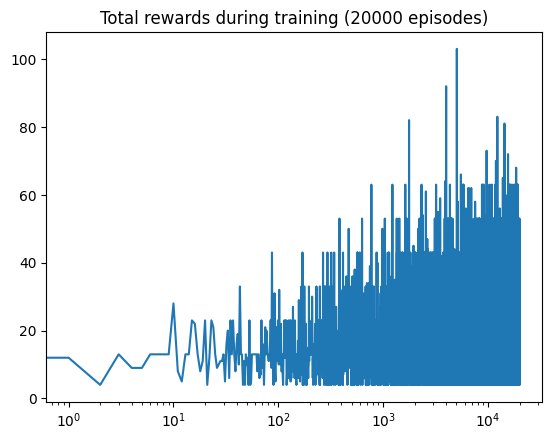

In [94]:
sarsagent = SarsaAgent()
agent_info = {"num_actions": 2, "num_states": 14*22, "epsilon": 0.7, "discount": 0.775,"alpha":0.325,"lambda":0.775}
agent_info["seed"] = 42
sarsagent.agent_init(agent_info,True)

start_time = time.time()
train_total_rewards = []
num_ep = 20000
for ep in range(num_ep):
    if ep % 1000 == 0 and ep >= 1000:
        print(f"Episode {ep} / {num_ep}")
    state = env.reset()[0]
    action = sarsagent.agent_start(state)
    tot_reward = 0
    while True:
        next_state, reward, done, _, info = env.step(action)
        state = next_state
        action = sarsagent.agent_step(reward,state)
        tot_reward += reward
        if done:
            sarsagent.agent_end(reward)
            break
    train_total_rewards.append(tot_reward)
end_time = time.time()
exec_time = end_time - start_time

sarsagent.set_exec_time(exec_time)
sarsagent.set_train_rewards(train_total_rewards)

plt.plot(list(range(len(train_total_rewards))),train_total_rewards)
plt.title(f"Total rewards during training ({num_ep} episodes)")
plt.xscale("log")
plt.show()






### Evaluation of SARSA agent

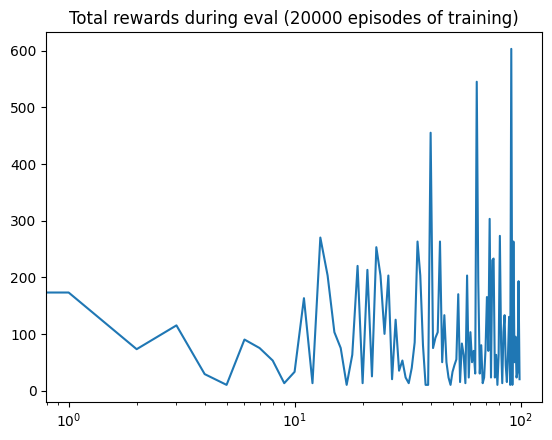

In [95]:
test_total_rewards = []
test_scores = []

for ep in range(100):
    state = env.reset()[0]
    action = sarsagent.argmax([sarsagent.Q[(state,0)],sarsagent.Q[(state,1)]])
    tot_reward = 0
    while True:
        next_state, reward, done, _, info = env.step(action)
        state = next_state
        action = sarsagent.argmax([sarsagent.Q[(state,0)],sarsagent.Q[(state,1)]])
        tot_reward += reward
        if done:
            test_scores.append(info["score"])
            break
    test_total_rewards.append(tot_reward)

sarsagent.set_test_rewards(test_total_rewards)
sarsagent.set_test_scores(test_scores)

plt.plot(list(range(len(test_total_rewards))),test_total_rewards)
plt.title(f"Total rewards during eval ({num_ep} episodes of training)")
plt.xscale("log")
plt.show()

### Plot the scores during the eval

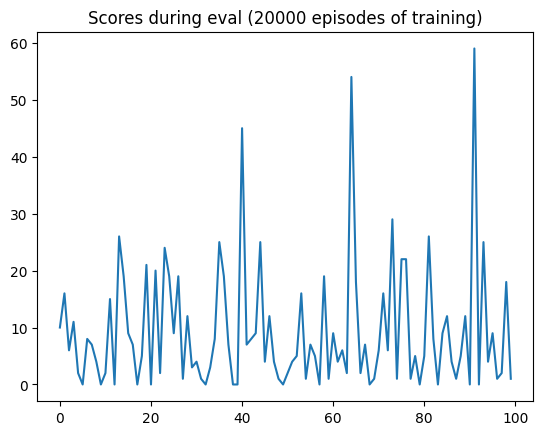

In [96]:
plt.plot(list(range(len(test_scores))),test_scores)
plt.title(f"Scores during eval ({num_ep} episodes of training)")
plt.show()

## Monte Carlo

In [87]:
class MCAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        self.gamma = agent_init_info["gamma"]
        self.epsilon = agent_init_info["epsilon"]
        self.Q = defaultdict(lambda:0)
        self.N = defaultdict(lambda:0)
        self.train_rewards = []
        self.train_scores = []

        self.test_rewards = []
        self.test_scores = []

    def select_action(self,state):
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return np.argmax([self.Q[(state,0)],self.Q[(state,1)]])

    def set_train_rewards(self,rewards):
        self.train_rewards = rewards

    def set_train_scores(self,scores):
        self.train_scores = scores

    def set_test_rewards(self,rewards):
        self.test_rewards = rewards

    def set_test_scores(self,scores):
        self.test_scores = scores

    def set_exec_time(self,time):
        self.exec_time = time

    def get_exec_time(self):
        return self.exec_time

    def get_train_rewards(self):
        return self.train_rewards

    def get_test_rewards(self):
        return self.test_rewards

    def get_train_scores(self):
        return self.train_scores

    def get_test_scores(self):
        return self.test_scores

    def G_update(self,episode):

        G = 0
        states = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            if not (state,action) in states:
                self.N[state,action] += 1
                self.Q[state,action] += (G-self.Q[state,action]) / self.N[state,action]
                states.add((state,action))

    def train(self,episodes):

        state = env.reset()[0]
        rewards_episodes = []
        scores_episodes = []
        for ep in range(episodes):
            episode=[]
            state = env.reset()[0]
            total_reward = 0
            while True:
                action = self.select_action(state)
                next_state, reward, done, _, info = env.step(action)
                episode.append((state,action,reward))
                total_reward += reward
                if done:
                    scores_episodes.append(info["score"])
                    break
                state = next_state
            self.G_update(episode)
            rewards_episodes.append(total_reward)
        self.set_train_rewards(rewards_episodes)
        self.set_train_scores(scores_episodes)

    def evaluate(self,episodes):

        rewards_episodes = []
        scores_episodes = []
        for ep in range(episodes):
            state = env.reset()[0]
            #print(f"Initial state is {state}")
            total_reward = 0
            while True:
                action = np.argmax([self.Q[(state,0)],self.Q[(state,1)]])
                #print(f"action is {action}")
                next_state, reward, done, _, info = env.step(action)
                total_reward += reward
                state = next_state
                #print(f"Next state is {state}")
                if done or info["score"] >= 10000:
                    scores_episodes.append(info["score"])
                    break
            rewards_episodes.append(total_reward)
        self.set_test_rewards(rewards_episodes)
        self.set_test_scores(scores_episodes)

    def plot_rewards(self):
        rewards_episodes = self.test_rewards
        plt.plot(list(range(len(rewards_episodes))),rewards_episodes)
        plt.title("Total rewards during evaluation")
        plt.xlabel("Episode")
        plt.ylabel("Total reward")
        plt.show()

    def plot_train_rewards(self):
        plt.plot(list(range(len(self.train_rewards))),self.train_rewards)
        plt.title("Total rewards during training")
        plt.xscale("log")
        plt.xlabel("Episode")
        plt.ylabel("Total reward")
        plt.show()

    def plot_scores(self):
        scores_episodes = self.test_scores
        plt.plot(list(range(len(scores_episodes))),scores_episodes)
        plt.title("Total scores during evaluation")
        plt.xlabel("Episode")
        plt.ylabel("Total score")
        plt.show()

    def plot_train_scores(self):
        plt.plot(list(range(len(self.train_scores))),self.train_scores)
        plt.title("Total scores during training")
        plt.xlabel("Episode")
        plt.ylabel("Total score")
        plt.xscale("log")
        plt.show()

    def get_Q(self):
        return self.Q

    def plot_Q_value(self):

        filtered_data = {key[0]: val for key, val in self.Q.items() if key[1] == 0}
        points = np.array(list(filtered_data.keys()))

        x_vals = [key[0][0] for key in self.Q.keys() if key[1] == 0]
        y_vals = [key[0][1] for key in self.Q.keys() if key[1] == 0]
        z_vals = [self.Q[key] for key in self.Q.keys() if key[1] == 0]


        x_grid = np.linspace(min(x_vals), max(x_vals), len(np.unique(x_vals)))
        y_grid = np.linspace(min(y_vals), max(y_vals), len(np.unique(y_vals)))
        x_grid, y_grid = np.meshgrid(x_grid, y_grid)

        # Interpolate z values onto grid
        z_grid = griddata(points, z_vals, (x_grid, y_grid), method='cubic')

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot using scatter
        surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis')

        # Labels and title
        ax.set_xlabel('Horizontal distance to wall')
        ax.set_ylabel('Vertical distance to hole')
        ax.set_zlabel('Q value')
        ax.set_title('Q values for action = 0')

        # Show the plot
        plt.colorbar(surf)
        plt.show()

        filtered_data = {key[0]: val for key, val in self.Q.items() if key[1] == 1}
        points = np.array(list(filtered_data.keys()))

        x_vals = [key[0][0] for key in self.Q.keys() if key[1] == 1]
        y_vals = [key[0][1] for key in self.Q.keys() if key[1] == 1]
        z_vals = [self.Q[key] for key in self.Q.keys() if key[1] == 1]

        x_grid = np.linspace(min(x_vals), max(x_vals), len(np.unique(x_vals)))
        y_grid = np.linspace(min(y_vals), max(y_vals), len(np.unique(y_vals)))
        x_grid, y_grid = np.meshgrid(x_grid, y_grid)

        # Interpolate z values onto grid
        z_grid = griddata(points, z_vals, (x_grid, y_grid), method='cubic')

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot using scatter
        surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis')
        # Labels and title
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        ax.set_title('Q values for action = 1')

        # Show the plot
        plt.colorbar(surf)
        plt.show()






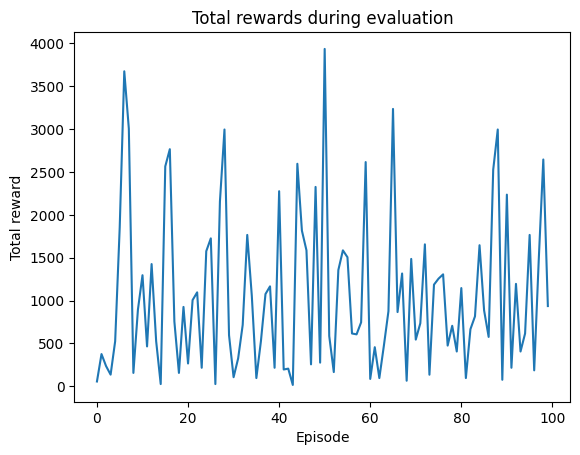

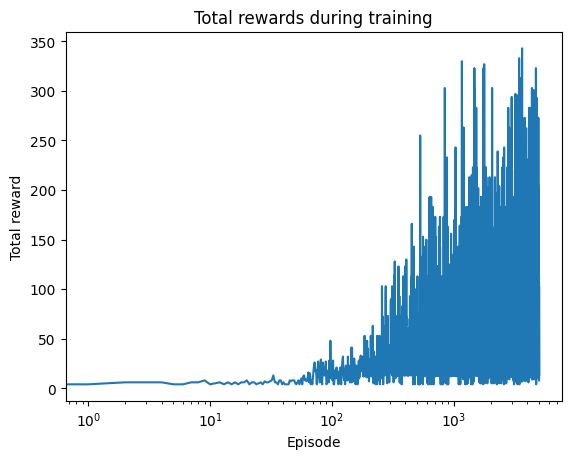

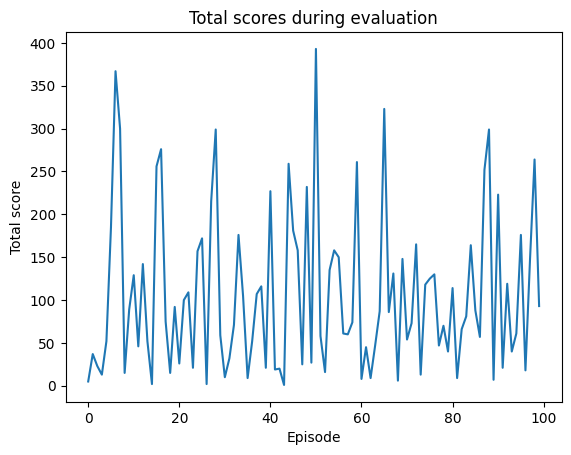

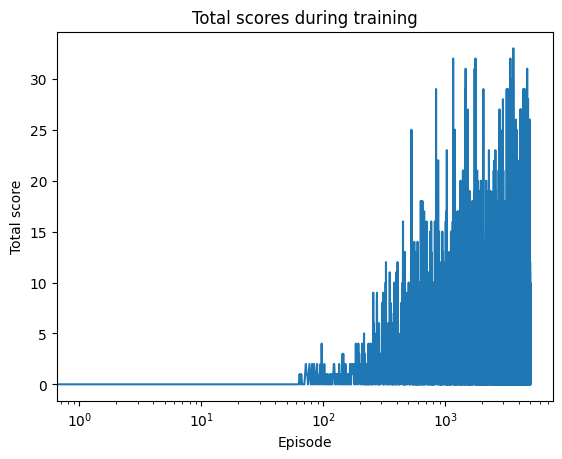

In [88]:
arguments = {
    "gamma": 0.9,
    "epsilon": 0.2
}

mc = MCAgent()
mc.agent_init(arguments)

start_time = time.time()
mc.train(5000)
end_time = time.time()
exec_time = end_time - start_time
mc.set_exec_time(exec_time)
mc.evaluate(100)
mc.plot_rewards()
mc.plot_train_rewards()
mc.plot_scores()
mc.plot_train_scores()

### Plot Q Values

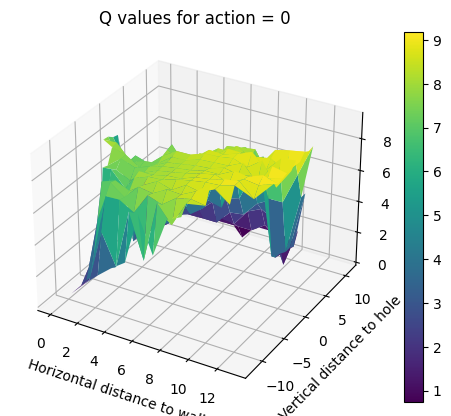

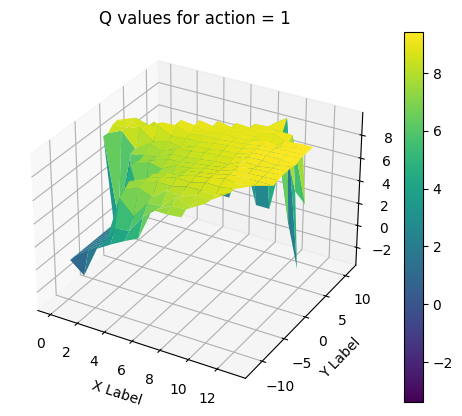

In [62]:
mc.plot_Q_value()

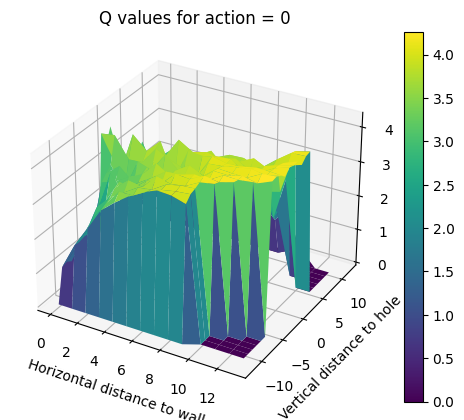

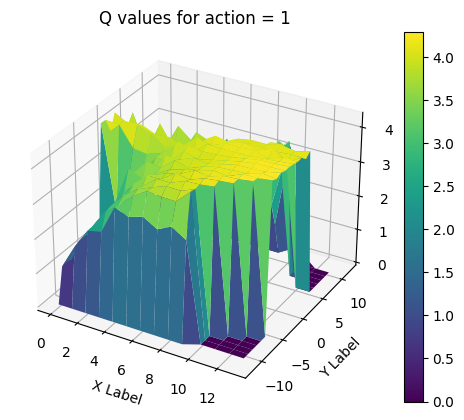

In [97]:
sarsagent.plot_Q_value()

### Compare the results of the two agents

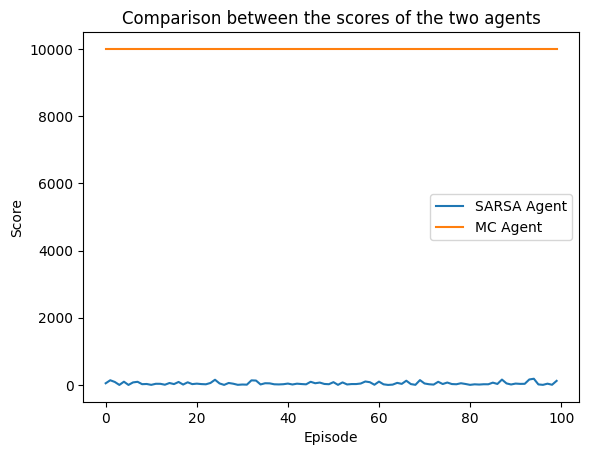

In [64]:
sarsa_test_scores = sarsagent.get_test_scores()
mc_test_scores = mc.get_test_scores()

plt.plot(list(range(len(sarsa_test_scores))),sarsa_test_scores,label="SARSA Agent")
plt.plot(list(range(len(mc_test_scores))),mc_test_scores,label="MC Agent")
plt.title("Comparison between the scores of the two agents")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()
plt.show()

### Exec time

In [65]:
print(f"MC exec time is {mc.get_exec_time()}")
print(f"SARSA exec time is {sarsagent.get_exec_time()}")

MC exec time is 28.80627965927124
SARSA exec time is 97.2018654346466


In [80]:
sarsa_times = []
mc_times = []
for length in [100,500,1000,2000,5000,10000]:
  sarsagent = SarsaAgent()
  agent_info = {"num_actions": 2, "num_states": 14*22, "epsilon": 0.7, "discount": 0.775,"alpha":0.325,"lambda":0.775}
  agent_info["seed"] = 42
  sarsagent.agent_init(agent_info,True)

  start_time = time.time()
  train_total_rewards = []
  num_ep = length
  for ep in range(num_ep):
      if ep % 1000 == 0 and ep >= 1000:
          print(f"Episode {ep} / {num_ep}")
      state = env.reset()[0]
      action = sarsagent.agent_start(state)
      tot_reward = 0
      while True:
          next_state, reward, done, _, info = env.step(action)
          state = next_state
          action = sarsagent.agent_step(reward,state)
          tot_reward += reward
          if done:
              sarsagent.agent_end(reward)
              break
      train_total_rewards.append(tot_reward)
  end_time = time.time()
  exec_time = end_time - start_time

  sarsa_times.append(exec_time)



  arguments = {
    "gamma": 0.9,
    "epsilon": 0.2
}

  mc = MCAgent()
  mc.agent_init(arguments)

  start_time = time.time()
  mc.train(length)
  end_time = time.time()
  exec_time = end_time - start_time
  mc.set_exec_time(exec_time)

  mc_times.append(exec_time)



KeyboardInterrupt: 

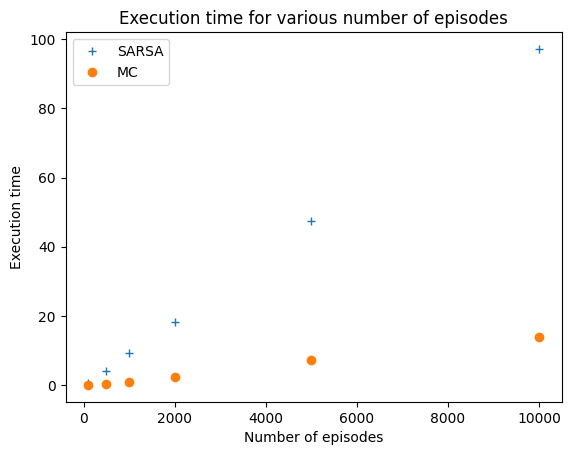

In [79]:
plt.plot([100,500,1000,2000,5000,10000],sarsa_times,"+",label="SARSA")
plt.plot([100,500,1000,2000,5000,10000],mc_times,"o",label="MC")
plt.title("Execution time for various number of episodes")
plt.legend()
plt.xlabel("Number of episodes")
plt.ylabel("Execution time")
plt.show()

### The other Text Flappy Bird environment

In [68]:
# initiate environment
env = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @             ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
(Flap)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
(Flap)
Text Flappy Bird!
Score: 0
----------------------
[                |   ]
[                |   ]
[                |   ]
[                |   ]
[       

In [69]:
env.reset()

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0

In [70]:
env.action_space

Discrete(2)

In [71]:
env.observation_space

Box(0, 3, (20, 15), int32)

In [72]:
action = env.action_space.sample()
print(f"ACTION = {action}")
env.step(action)

ACTION = 1


(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2

### Flappy Bird gym

### Slightly different environment

In [46]:
env1 = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
env2 = gym.make('TextFlappyBird-v0', height = 15, width = 15, pipe_gap = 3)

Text(0, 0.5, 'Score')

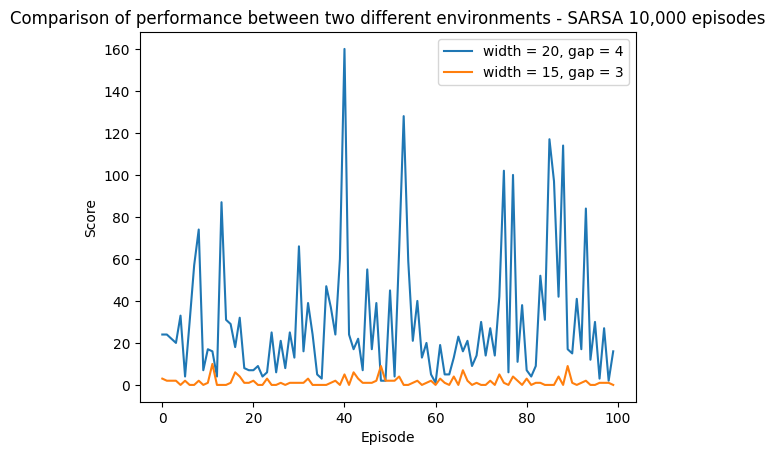

In [75]:
scores = []
for env in [env1,env2]:
  test_total_rewards = []
  test_scores = []

  for ep in range(100):
      state = env.reset()[0]
      action = sarsagent.argmax([sarsagent.Q[(state,0)],sarsagent.Q[(state,1)]])
      tot_reward = 0
      while True:
          next_state, reward, done, _, info = env.step(action)
          state = next_state
          action = sarsagent.argmax([sarsagent.Q[(state,0)],sarsagent.Q[(state,1)]])
          tot_reward += reward
          if done:
              test_scores.append(info["score"])
              break
      test_total_rewards.append(tot_reward)

  sarsagent.set_test_rewards(test_total_rewards)
  sarsagent.set_test_scores(test_scores)

  scores.append(test_scores)

plt.plot(list(range(100)),scores[0],label = "width = 20, gap = 4")
plt.plot(list(range(100)),scores[1],label = "width = 15, gap = 3")
plt.legend()
plt.title("Comparison of performance between two different environments - SARSA 10,000 episodes")
plt.xlabel("Episode")
plt.ylabel("Score")

uUUU
uUUU


Text(0, 0.5, 'Score')

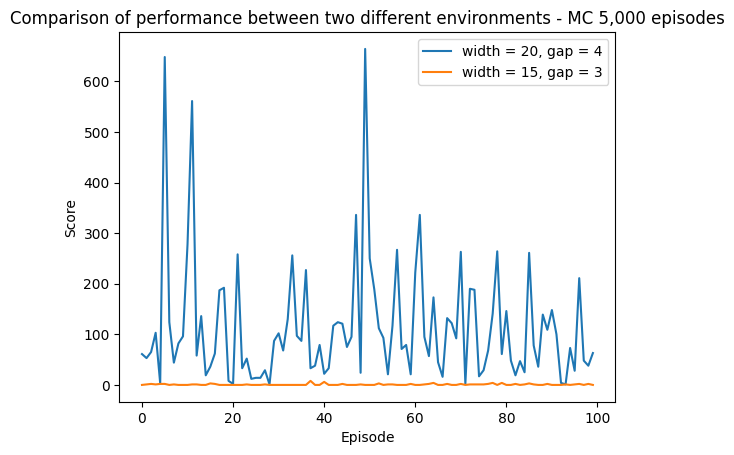

In [90]:
scores = []
for env in [env1,env2]:
  print("uUUU")
  mc.evaluate(100)
  scores.append(mc.get_test_scores())


plt.plot(list(range(100)),scores[0],label = "width = 20, gap = 4")
plt.plot(list(range(100)),scores[1],label = "width = 15, gap = 3")
plt.legend()
plt.title("Comparison of performance between two different environments - MC 5,000 episodes")
plt.xlabel("Episode")
plt.ylabel("Score")